Importowanie bibliotek
W tej sekcji wczytujemy niezbędne biblioteki do przetwarzania danych, wizualizacji oraz tworzenia i trenowania modelu. Kluczowe użyte biblioteki to:

-numpy: do obliczeń numerycznych.
-pandas: do manipulacji danymi w formie tabelarycznej.
-matplotlib i seaborn: do wizualizacji danych.
-sklearn: do wczytania zbioru danych Iris, standaryzacji cech oraz podziału danych na zbiory.

Standaryzacja cech
Zastosowanie standaryzacji cech za pomocą klasy StandardScaler z sklearn. Proces ten:

Skaluje każdą cechę tak, aby miała średnią równą 0 i odchylenie standardowe równe 1.
Standaryzacja jest niezbędna, aby cechy o różnych skalach (np. długość i szerokość) miały taki sam wpływ na model.

Wczytanie zbioru danych Iris
Za pomocą biblioteki sklearn wczytujemy wbudowany zbiór danych Iris, który zawiera informacje o trzech gatunkach irysów (setosa, versicolor, virginica). Dane te zawierają cechy opisujące długość i szerokość działek kielicha i płatków kwiatów oraz ich klasy (gatunki). Następnie:

Przypisujemy zmienne cech (X) oraz zmienne docelowe (y).
Tworzymy pomocnicze listy z nazwami cech oraz klas.

Wyświetlamy liczbę próbek w poszczególnych zbiorach (treningowy, walidacyjny, testowy), aby upewnić się, że dane zostały poprawnie podzielone i ich rozmiar jest zgodny z oczekiwaniami.

In [1]:
# Importowanie bibliotek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Wczytanie zbioru danych Iris
iris = load_iris()
X, y = iris.data, iris.target
feature_names = iris.feature_names
class_names = iris.target_names

# Standaryzacja cech
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Podział na zbiory treningowe, walidacyjne i testowe
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Wyświetlenie liczby próbek
print(f"Liczba próbek w zbiorze treningowym: {X_train.shape[0]}")
print(f"Liczba próbek w zbiorze walidacyjnym: {X_val.shape[0]}")
print(f"Liczba próbek w zbiorze testowym: {X_test.shape[0]}")


Liczba próbek w zbiorze treningowym: 105
Liczba próbek w zbiorze walidacyjnym: 22
Liczba próbek w zbiorze testowym: 23


W tej sekcji importujemy niezbędne moduły z biblioteki PyTorch:
torch: główna biblioteka do operacji na tensorach.
DataLoader, TensorDataset z modułu torch.utils.data: używane do tworzenia zbiorów danych i iterowania po nich podczas treningu.
    
Konwersja na tensory PyTorch
Dane podzielone na zbiory (treningowy, walidacyjny, testowy) są konwertowane na tensory PyTorch, co jest wymagane do ich dalszego przetwarzania przez modele sieci neuronowych.
Typ danych jest precyzowany:
torch.float32: dla cech (X), aby zapewnić zgodność z modelami PyTorch.
torch.long: dla etykiet klas (y), co jest wymagane przez funkcje strat, takie jak CrossEntropyLoss.
    
Tworzenie TensorDataset i DataLoader.
TensorDataset: tworzy zbiór danych z tensorów cech (X) i etykiet (y), które są ze sobą powiązane.
DataLoader: pozwala iterować po danych w partiach (batch_size) oraz opcjonalnie losowo mieszać dane (shuffle).
Utworzono trzy zbiory:
train_loader: do treningu, z losowym mieszaniem próbek.
val_loader: do walidacji, bez mieszania.
test_loader: do testowania, bez mieszania.

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Konwersja na tensory PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Tworzenie TensorDataset i DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Importujemy moduł torch.nn jako nn, który zawiera klasy i funkcje umożliwiające budowę modeli sieci neuronowych w PyTorch.

Tworzymy klasę sieci neuronowej dziedziczącą po nn.Module.
Klasa ta reprezentuje wielowarstwową sieć neuronową do wieloklasowej klasyfikacji.
Posiada dwie warstwy ukryte oraz możliwość dostosowania funkcji aktywacji.

Metoda __init__
W tej metodzie definiujemy architekturę sieci:

self.fc1: pierwsza warstwa w pełni połączona (input → hidden layer 1).
self.fc2: druga warstwa w pełni połączona (hidden layer 1 → hidden layer 2).
self.fc3: warstwa wyjściowa (hidden layer 2 → output).
self.activation1, self.activation2: funkcje aktywacji, które są wybierane dynamicznie (np. ReLU lub Tanh).
    
Metoda forward
Metoda implementuje przepływ danych przez sieć:

Dane wejściowe przechodzą przez self.fc1 i są przetwarzane przez funkcję aktywacji self.activation1.
Wynik jest przekazywany przez self.fc2 i funkcję aktywacji self.activation2.
Wynik końcowy przechodzi przez warstwę wyjściową self.fc3.

In [3]:
import torch.nn as nn

# Definicja modelu
class MulticlassNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, activation1, activation2):
        super(MulticlassNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.activation1 = activation1
        self.activation2 = activation2

    def forward(self, x):
        x = self.activation1(self.fc1(x))
        x = self.activation2(self.fc2(x))
        x = self.fc3(x)
        return x


Importujemy:

torch.optim jako optim – zawiera optymalizatory takie jak SGD czy Adam, które będą używane w procesie treningu.
accuracy_score z sklearn.metrics – funkcja do obliczania dokładności predykcji modelu w zadaniach klasyfikacyjnych.

Funkcja train – trening sieci neuronowej
Funkcja odpowiada za przeprowadzenie pojedynczej epoki treningu na zbiorze treningowym:

Przełączenie modelu w tryb treningowy – model.train().
Zerowanie gradientów – optimizer.zero_grad(), aby uniknąć kumulacji gradientów z poprzednich iteracji.
Przepływ danych przez model:
Dane treningowe przechodzą przez model w celu obliczenia predykcji.
Obliczanie straty pomiędzy predykcjami a rzeczywistymi etykietami.
Propagacja wsteczna – loss.backward() oblicza gradienty dla wszystkich parametrów modelu.
Aktualizacja wag – optimizer.step() zmienia parametry modelu na podstawie gradientów.
Funkcja zwraca stratę (loss) dla bieżącej epoki.

Funkcja validate – walidacja modelu
Funkcja walidacyjna sprawdza jakość modelu na zbiorze walidacyjnym:

Przełączenie modelu w tryb ewaluacji – model.eval().
Wyłączenie obliczania gradientów – torch.no_grad(), co przyspiesza obliczenia i zmniejsza zużycie pamięci.
Przepływ danych przez model:
Obliczanie predykcji na zbiorze walidacyjnym.
Obliczanie straty (loss) na podstawie predykcji.
Obliczenie dokładności:
Przewidywane etykiety są porównywane z rzeczywistymi w celu obliczenia dokładności klasyfikacji.
Funkcja zwraca stratę (loss) i dokładność (accuracy) dla zbioru walidacyjnego.

In [4]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Funkcja treningu
def train(model, optimizer, criterion, X_train, y_train):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    return loss.item()

# Funkcja walidacji
def validate(model, criterion, X_val, y_val):
    model.eval()
    with torch.no_grad():
        output = model(X_val)
        loss = criterion(output, y_val)
        _, predicted = torch.max(output, 1)
        accuracy = accuracy_score(y_val, predicted)
    return loss.item(), accuracy


Funkcja product generuje iloczyn kartezjański podanych zbiorów.
Jest to pomocne w testowaniu wszystkich możliwych kombinacji hiperparametrów modelu.

Definicja zakresów hiperparametrów
Zdefiniowano zakresy wartości dla różnych hiperparametrów, które będą używane podczas treningu modelu:

hidden_layer_sizes – zestawy rozmiarów dwóch warstw ukrytych (np. (8, 4), (16, 8)).
learning_rates – różne wartości współczynnika uczenia (np. 0.01, 0.001).
epochs_list – liczba epok treningowych (np. 100, 200).
activation_functions – słownik, który przypisuje nazwy funkcji aktywacji ("ReLU", "Tanh") do ich implementacji w PyTorch.

Generowanie wszystkich kombinacji hiperparametrów
W tej sekcji kodu generujemy wszystkie możliwe kombinacje hiperparametrów:

Zastosowanie product – iteracja po wszystkich wartościach zdefiniowanych zakresów, co pozwala uzyskać każdą możliwą kombinację.
Tworzenie listy słowników hyperparams – każda kombinacja hiperparametrów jest zapisywana jako słownik zawierający:
Rozmiary warstw ukrytych (hidden_size1, hidden_size2).
Współczynnik uczenia (learning_rate).
Liczbę epok (epochs).
Funkcje aktywacji (activation1, activation2) wraz z ich nazwami (activation1_name, activation2_name).
Wyświetlenie liczby kombinacji – liczba generowanych kombinacji jest wypisana za pomocą funkcji print.

In [5]:
from itertools import product

# Definicja zakresów hiperparametrów
hidden_layer_sizes = [(8, 4), (16, 8)]
learning_rates = [0.01, 0.001]
epochs_list = [100, 200]
activation_functions = {
    "ReLU": nn.ReLU(),
    "Tanh": nn.Tanh()
}

# Generowanie wszystkich kombinacji
hyperparams = [
    {
        "hidden_size1": h1,
        "hidden_size2": h2,
        "learning_rate": lr,
        "epochs": epochs,
        "activation1": activation1,
        "activation2": activation2
    }
    for (h1, h2), lr, epochs, (activation1_name, activation1), (activation2_name, activation2)
    in product(hidden_layer_sizes, learning_rates, epochs_list, activation_functions.items(), activation_functions.items())
]

print(f"Liczba kombinacji hiperparametrów: {len(hyperparams)}")


Liczba kombinacji hiperparametrów: 32


Na początku zdefiniowano puste listy do przechowywania:

Wyników wszystkich testowanych modeli (results).
Strat treningowych dla każdego modelu (all_train_losses).
Strat walidacyjnych dla każdego modelu (all_val_losses).
Dokładności walidacyjnych dla każdego modelu (all_val_accuracies).

Iteracja po kombinacjach hiperparametrów
Pętla for iteruje przez wszystkie kombinacje hiperparametrów wygenerowane wcześniej. Dla każdej kombinacji:

Wyświetlany jest numer iteracji oraz wartości testowanych hiperparametrów.
Następuje inicjalizacja modelu (MulticlassNN), optymalizatora (Adam) i funkcji straty (CrossEntropyLoss).

Inicjalizacja zmiennych treningowych
Przygotowanie zmiennych do przechowywania strat i dokładności:

train_losses – lista strat na zbiorze treningowym.
val_losses – lista strat na zbiorze walidacyjnym.
val_accuracies – lista dokładności na zbiorze walidacyjnym. Dodatkowo inicjalizowane są:
best_val_loss – najlepsza wartość straty walidacyjnej (ustawiona na nieskończoność).
patience_counter – licznik epok, w których nie nastąpiła poprawa wyniku.

Pętla treningowa
Wewnętrzna pętla for przechodzi przez określoną liczbę epok:

Trening: Wywołuje funkcję train i zapisuje wynik straty treningowej.
Walidacja: Wywołuje funkcję validate, która zwraca stratę walidacyjną i dokładność. Wyniki są zapisywane w odpowiednich listach.
Early Stopping: Porównuje stratę walidacyjną z najlepszą dotychczasową wartością:
Jeśli nastąpi poprawa, resetuje licznik cierpliwości (patience_counter).
Jeśli nie, zwiększa licznik. Po przekroczeniu wartości patience, pętla treningowa zostaje przerwana.

In [6]:
results = []  # Lista wyników
all_train_losses = []
all_val_losses = []
all_val_accuracies = []

for idx, params in enumerate(hyperparams):
    print(f"Trening modelu {idx + 1}/{len(hyperparams)} z hiperparametrami: {params}")
    
    # Inicjalizacja modelu
    model = MulticlassNN(
        input_size=4, 
        hidden_size1=params["hidden_size1"], 
        hidden_size2=params["hidden_size2"], 
        output_size=len(class_names), 
        activation1=params["activation1"], 
        activation2=params["activation2"]
    )
    
    optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])
    criterion = nn.CrossEntropyLoss()
    
    train_losses, val_losses, val_accuracies = [], [], []
    best_val_loss = float("inf")
    patience_counter = 0
    patience = 5  # Early stopping patience
    
    for epoch in range(params["epochs"]):
        # Trenowanie
        train_loss = train(model, optimizer, criterion, X_train_tensor, y_train_tensor)
        train_losses.append(train_loss)
        
        # Walidacja
        val_loss, val_accuracy = validate(model, criterion, X_val_tensor, y_val_tensor)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping w epoce {epoch + 1}")
                break
    
    # Zapis wyników
    results.append({
        "hidden_size1": params["hidden_size1"],
        "hidden_size2": params["hidden_size2"],
        "learning_rate": params["learning_rate"],
        "epochs": epoch + 1,
        "activation1": params["activation1"].__class__.__name__,
        "activation2": params["activation2"].__class__.__name__,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "final_val_loss": val_losses[-1],
        "final_val_accuracy": val_accuracies[-1]
    })
    
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_val_accuracies.append(val_accuracies)


Trening modelu 1/32 z hiperparametrami: {'hidden_size1': 8, 'hidden_size2': 4, 'learning_rate': 0.01, 'epochs': 100, 'activation1': ReLU(), 'activation2': ReLU()}
Trening modelu 2/32 z hiperparametrami: {'hidden_size1': 8, 'hidden_size2': 4, 'learning_rate': 0.01, 'epochs': 100, 'activation1': ReLU(), 'activation2': Tanh()}
Early stopping w epoce 95
Trening modelu 3/32 z hiperparametrami: {'hidden_size1': 8, 'hidden_size2': 4, 'learning_rate': 0.01, 'epochs': 100, 'activation1': Tanh(), 'activation2': ReLU()}
Early stopping w epoce 94
Trening modelu 4/32 z hiperparametrami: {'hidden_size1': 8, 'hidden_size2': 4, 'learning_rate': 0.01, 'epochs': 100, 'activation1': Tanh(), 'activation2': Tanh()}
Trening modelu 5/32 z hiperparametrami: {'hidden_size1': 8, 'hidden_size2': 4, 'learning_rate': 0.01, 'epochs': 200, 'activation1': ReLU(), 'activation2': ReLU()}
Early stopping w epoce 81
Trening modelu 6/32 z hiperparametrami: {'hidden_size1': 8, 'hidden_size2': 4, 'learning_rate': 0.01, 'epoc

po zakończeniu wszystkich iteracji wyniki zapisane w liście results są konwertowane do formatu DataFrame za pomocą funkcji pd.DataFrame(). Jest to kluczowy krok, który pozwala na łatwą analizę danych w sposób tabelaryczny i umożliwia późniejsze sortowanie oraz wizualizację.

Ekstrakcja końcowych wartości strat i dokładnosci
Ponieważ dla każdej konfiguracji przechowywane są listy strat (val_losses) i dokładności (val_accuracies), należy wybrać ich ostatnie elementy, które reprezentują wyniki z ostatniej epoki treningu.
Do tego celu używane są funkcje apply z wyrażeniem lambda.

results_df["final_val_loss"] – zawiera ostatnie wartości strat walidacyjnych.
results_df["final_val_accuracy"] – zawiera ostatnie wartości dokładności walidacyjnych.

Sortowanie wyników
Dane w DataFrame są sortowane według:
final_val_accuracy – dokładność walidacyjna w porządku malejącym (najlepsze modele na górze).
final_val_loss – strata walidacyjna w porządku rosnącym (mniejsze wartości są lepsze).
Sortowanie pozwala szybko zidentyfikować najlepsze modele.

Na końcu wyświetlenie 5 najlepszych modeli

In [7]:
# Konwersja wyników do DataFrame
results_df = pd.DataFrame(results)
results_df["final_val_loss"] = results_df["val_losses"].apply(lambda x: x[-1])
results_df["final_val_accuracy"] = results_df["val_accuracies"].apply(lambda x: x[-1])

# Sortowanie wyników
sorted_results = results_df.sort_values(by=["final_val_accuracy", "final_val_loss"], ascending=[False, True])

# Wyświetlenie najlepszych modeli
print("Top 5 najlepszych modeli:")
print(sorted_results.head(5))


Top 5 najlepszych modeli:
    hidden_size1  hidden_size2  learning_rate  epochs activation1 activation2  \
23            16             8           0.01      68        Tanh        Tanh   
6              8             4           0.01     151        Tanh        ReLU   
2              8             4           0.01      94        Tanh        ReLU   
22            16             8           0.01      66        Tanh        ReLU   
4              8             4           0.01      81        ReLU        ReLU   

                                         train_losses  \
23  [1.2198669910430908, 1.1455351114273071, 1.078...   
6   [1.0851348638534546, 1.0720797777175903, 1.059...   
2   [1.0483421087265015, 1.028469443321228, 1.0084...   
22  [1.2250239849090576, 1.1627196073532104, 1.118...   
4   [1.1407437324523926, 1.1274179220199585, 1.116...   

                                           val_losses  \
23  [1.1388990879058838, 1.0749015808105469, 1.016...   
6   [1.0689390897750854, 1.055

Najlepszy model jest wybierany jako pierwszy wiersz z posortowanego DataFrame (sorted_results). Ten model ma najwyższą dokładność walidacyjną i najniższą stratę walidacyjną w przypadku remisu.

Ekstrakcja strat treningowych i walidacyjnych
Dane o stratach treningowych (train_losses) oraz walidacyjnych (val_losses) dla najlepszego modelu są pobierane z odpowiednich kolumn w DataFrame.

Tworzenie wykresu strat
Wykres przedstawia zmiany strat treningowych i walidacyjnych w kolejnych epokach dla najlepszego modelu.

Osie:
X (Epoka): Liczba iteracji treningowych.
Y (Strata): Wartość funkcji kosztu.
Dwa wykresy na jednym rysunku:
Straty treningowe: Niebieska linia ("blue").
Straty walidacyjne: Czerwona linia ("red").
Elementy pomocnicze:
plt.title: Ustawia tytuł wykresu.
plt.xlabel, plt.ylabel: Opisy osi
plt.legend: Legenda 
plt.grid: Siatka 

Wykres ten umożliwia wizualne porównanie strat treningowych i walidacyjnych. Dzięki temu można ocenić, czy model dobrze generalizuje dane walidacyjne, czy też występuje nadmierne dopasowanie

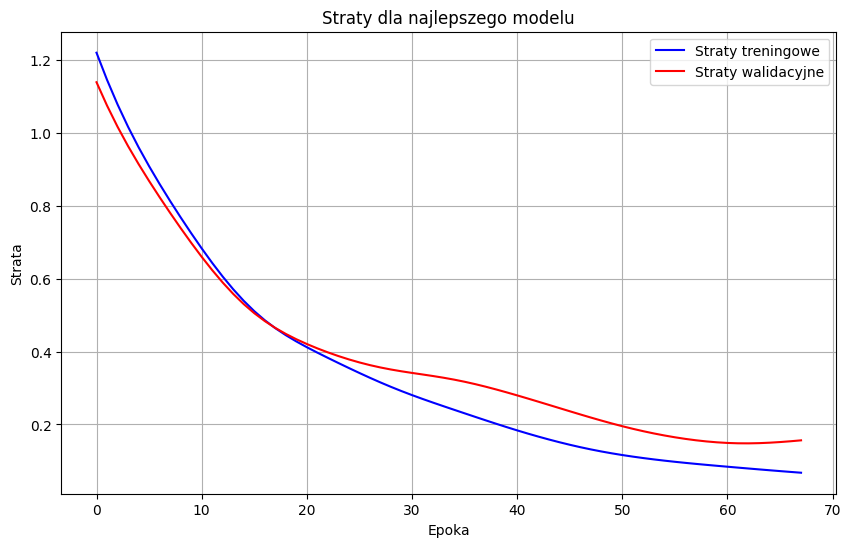

In [8]:
# Wizualzacja strat dla najlepszego modelu
best_model = sorted_results.iloc[0]
train_losses = best_model["train_losses"]
val_losses = best_model["val_losses"]

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Straty treningowe", color="blue")
plt.plot(val_losses, label="Straty walidacyjne", color="red")
plt.title("Straty dla najlepszego modelu")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.grid(True)
plt.show()


Z wyników najlepszego modelu (wybranego z DataFrame sorted_results) pobierane są dane o dokładności walidacyjnej (val_accuracies) dla każdej epoki. Te dane pozwalają na analizę zmian dokładności modelu w trakcie treningu.

Tworzenie wykresu dokładności
Wykres przedstawia zmiany dokładności walidacyjnej w kolejnych epokach dla najlepszego modelu.

Osie:
X (Epoka): Liczba iteracji treningowych.
Y (Dokładność): Wartość dokładności (w skali od 0 do 1).
Zielona linia ("green") reprezentuje dokładność walidacyjną.

Wizualizacja pokazuje, jak zmieniała się dokładność walidacyjna modelu w trakcie kolejnych epok treningu. Dzięki temu można ocenić, czy dokładność stabilizuje się w późniejszych epokach, co jest oznaką zbieżności modelu.

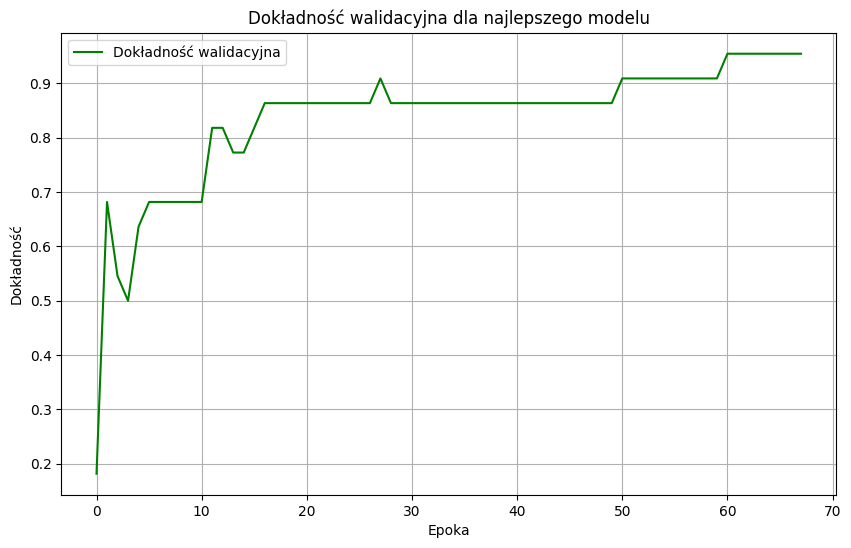

In [9]:
# Dokładność walidacyjna dla najlepszego modelu
val_accuracies = best_model["val_accuracies"]

plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label="Dokładność walidacyjna", color="green")
plt.title("Dokładność walidacyjna dla najlepszego modelu")
plt.xlabel("Epoka")
plt.ylabel("Dokładność")
plt.legend()
plt.grid(True)
plt.show()


Wszystkie liczby epok wykorzystane w treningu różnych konfiguracji modelu są pobierane z kolumny epochs w DataFrame results_df. Dane te zostaną użyte do stworzenia histogramu, który pokaże rozkład liczby epok w badanych modelach.

Tworzenie histogramu
Histogram prezentuje, ile modeli trenowano przez określoną liczbę epok. Wykorzystuje on bibliotekę Seaborn do wizualizacji.

Parametry histogramu:
bins=10: Histogram podzielony na 10 przedziałów.
kde=True: Włączony wykres gęstości, który pokazuje wygładzoną wersję rozkładu.

Wizualizacja dostarcza informacji o tym, jak liczba epok została rozdzielona pomiędzy różne modele. Może to pomóc w identyfikacji trendów, takich jak:

Czy większość modeli trenowano przez niewielką liczbę epok.
Czy były jakieś konfiguracje, które wymagały większej liczby epok do zbieżności.

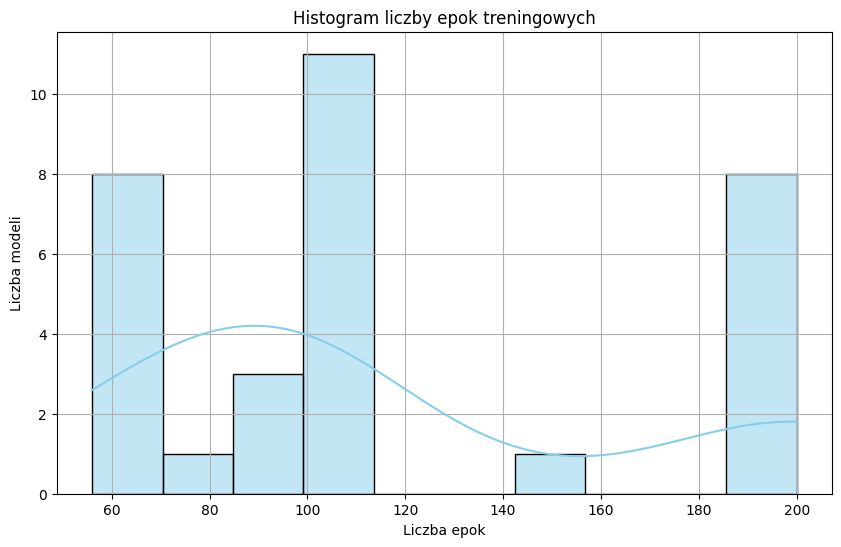

In [10]:
# Histogram czasu treningu
training_epochs = results_df["epochs"]

plt.figure(figsize=(10, 6))
sns.histplot(training_epochs, bins=10, kde=True, color="skyblue", edgecolor="black")
plt.title("Histogram liczby epok treningowych")
plt.xlabel("Liczba epok")
plt.ylabel("Liczba modeli")
plt.grid(True)
plt.show()


Dane do wykresu pochodzą z tabeli results_df. Analizowanymi kolumnami są:

activation1: Funkcja aktywacji zastosowana w pierwszej warstwie ukrytej.
final_val_accuracy: Ostateczna dokładność walidacyjna modelu.

Wykres typu boxplot przedstawia rozkład dokładności walidacyjnej dla różnych funkcji aktywacji w pierwszej warstwie sieci.

Parametry wykresu:

Oś X (x="activation1"): Funkcja aktywacji w pierwszej warstwie.
Oś Y (y="final_val_accuracy"): Ostateczna dokładność walidacyjna.
data=results_df: Dane źródłowe do wykresu.
palette="pastel": Kolorystyka wykresu w delikatnych odcieniach.
Opis osi:

Oś X: Wskazuje rodzaje funkcji aktywacji, np. ReLU, Tanh.
Oś Y: Przedstawia wartość dokładności walidacyjnej.

Rozkład wyników:
Boxplot pokazuje medianę dokładności walidacyjnej dla każdej funkcji aktywacji. Wskazuje również rozrzut danych (przedział międzykwartylowy) oraz wartości odstające.

Analiza porównawcza:
Możemy łatwo porównać, która funkcja aktywacji daje lepsze wyniki w pierwszej warstwie sieci.

C:\Users\Zuri\AppData\Local\Temp\ipykernel_18092\580773886.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="activation1", y="final_val_accuracy", data=results_df, palette="pastel")


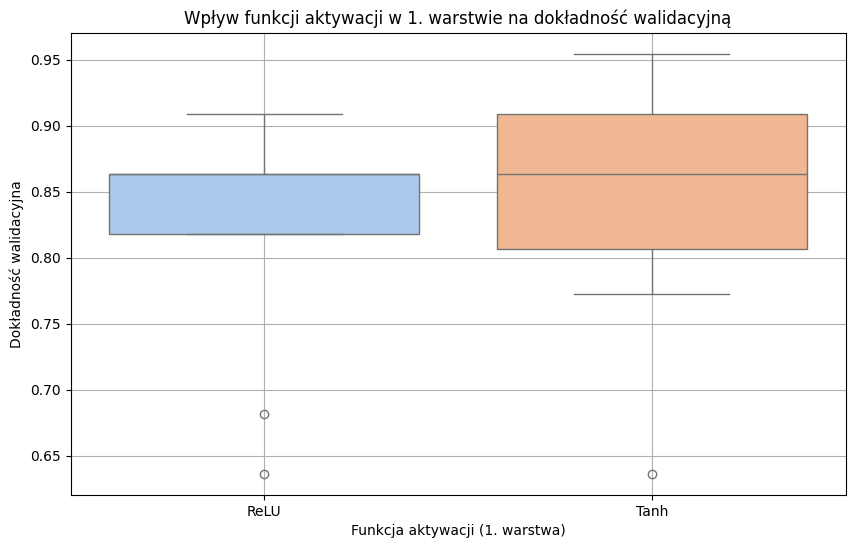

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="activation1", y="final_val_accuracy", data=results_df, palette="pastel")
plt.title("Wpływ funkcji aktywacji w 1. warstwie na dokładność walidacyjną")
plt.xlabel("Funkcja aktywacji (1. warstwa)")
plt.ylabel("Dokładność walidacyjna")
plt.grid(True)
plt.show()


Dane do wykresu pochodzą z tabeli results_df. Analizowane kolumny to:

activation2: Funkcja aktywacji zastosowana w drugiej warstwie ukrytej.
final_val_accuracy: Ostateczna dokładność walidacyjna modelu.

Wykres typu boxplot przedstawia rozkład dokładności walidacyjnej dla różnych funkcji aktywacji w drugiej warstwie sieci.

Parametry wykresu:

Oś X (x="activation2"): Funkcja aktywacji w drugiej warstwie.
Oś Y (y="final_val_accuracy"): Ostateczna dokładność walidacyjna.
data=results_df: Dane źródłowe do wykresu.

Rozkład wyników:
Boxplot pokazuje medianę dokładności walidacyjnej dla każdej funkcji aktywacji. Wskazuje również rozrzut danych (przedział międzykwartylowy) oraz wartości odstające.

Analiza porównawcza:
Możemy łatwo porównać, która funkcja aktywacji daje lepsze wyniki w drugiej warstwie sieci.

C:\Users\Zuri\AppData\Local\Temp\ipykernel_18092\2043238950.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="activation2", y="final_val_accuracy", data=results_df, palette="muted")


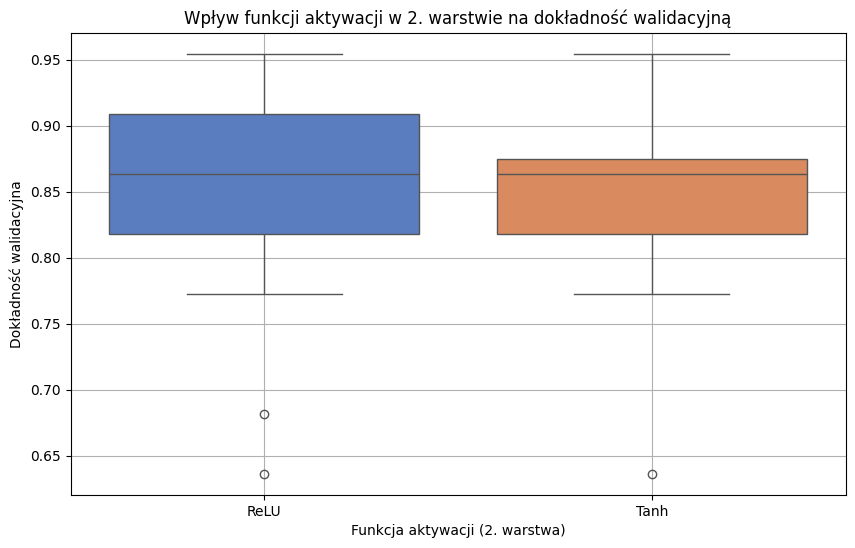

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="activation2", y="final_val_accuracy", data=results_df, palette="muted")
plt.title("Wpływ funkcji aktywacji w 2. warstwie na dokładność walidacyjną")
plt.xlabel("Funkcja aktywacji (2. warstwa)")
plt.ylabel("Dokładność walidacyjna")
plt.grid(True)
plt.show()


Dane do wykresu są pobrane z tabeli results_df. Analizowane kolumny to:

hidden_size1: Liczba neuronów w pierwszej warstwie ukrytej sieci neuronowej.
final_val_accuracy: Ostateczna dokładność walidacyjna modelu

Wykres przedstawia rozkład dokładności walidacyjnej dla różnych liczby neuronów w pierwszej warstwie sieci.

Parametry wykresu:

Oś X (x="hidden_size1"): Liczba neuronów w pierwszej warstwie ukrytej.
Oś Y (y="final_val_accuracy"): Ostateczna dokładność walidacyjna modelu.
data=results_df: Dane źródłowe do wykresu.

Rozkład wyników:
Wykres typu boxplot pokazuje medianę, przedział międzykwartylowy oraz ewentualne wartości odstające dla różnych liczby neuronów w pierwszej warstwie.

Porównanie:
Możemy łatwo zauważyć, czy większa liczba neuronów w pierwszej warstwieprzekłada się na wyższą dokładność walidacyjną modeli.

C:\Users\Zuri\AppData\Local\Temp\ipykernel_18092\860304384.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="hidden_size1", y="final_val_accuracy", data=results_df, palette="muted")


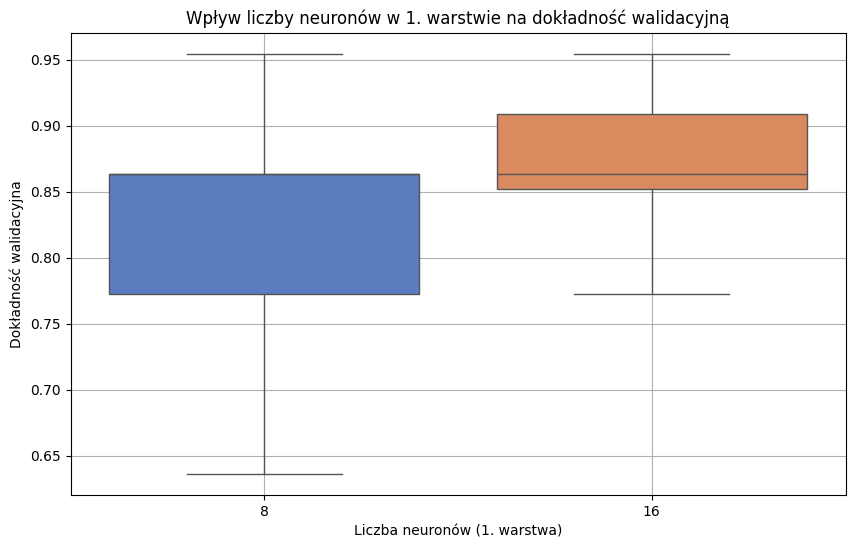

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="hidden_size1", y="final_val_accuracy", data=results_df, palette="muted")
plt.title("Wpływ liczby neuronów w 1. warstwie na dokładność walidacyjną")
plt.xlabel("Liczba neuronów (1. warstwa)")
plt.ylabel("Dokładność walidacyjna")
plt.grid(True)
plt.show()


Dane wykorzystane do stworzenia wykresu pochodzą z tabeli results_df. Analizowane kolumny to:

hidden_size2: Liczba neuronów w drugiej warstwie ukrytej sieci neuronowej.
final_val_accuracy: Ostateczna dokładność walidacyjna uzyskana przez modele.

Boxplot przedstawia rozkład dokładności walidacyjnej dla różnych liczby neuronów w drugiej warstwie sieci.

Parametry wykresu:

Oś X (x="hidden_size2"): Liczba neuronów w drugiej warstwie ukrytej.
Oś Y (y="final_val_accuracy"): Ostateczna dokładność walidacyjna modelu.
data=results_df: Dane źródłowe do analizy.

Rozkład wyników:
Boxplot przedstawia medianę dokładności walidacyjnej, przedziały międzykwartylowe oraz wartości odstające dla każdej liczby neuronów w drugiej warstwie.

Porównanie:
Możemy łatwo zauważyć, czy większa liczba neuronów w drugiej warstwieprzekłada się na wyższą dokładność walidacyjną modeli.

C:\Users\Zuri\AppData\Local\Temp\ipykernel_18092\3095147772.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="hidden_size2", y="final_val_accuracy", data=results_df, palette="coolwarm")


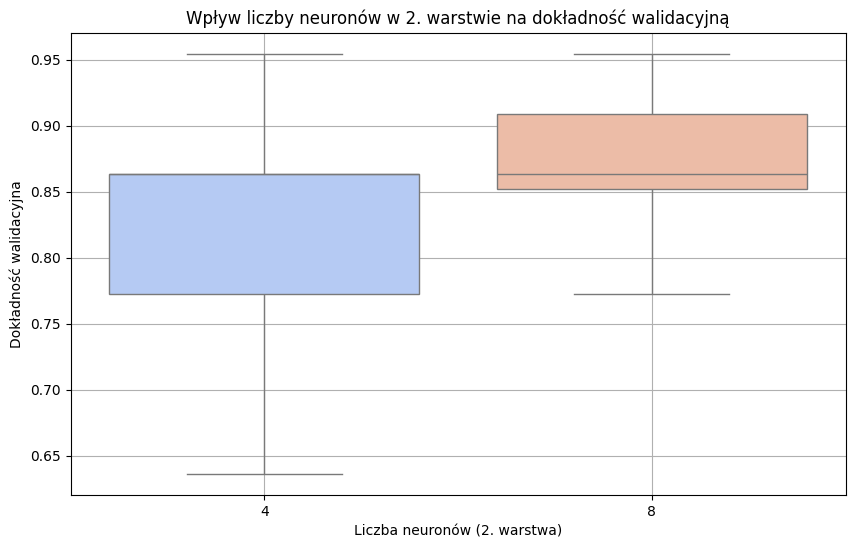

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="hidden_size2", y="final_val_accuracy", data=results_df, palette="coolwarm")
plt.title("Wpływ liczby neuronów w 2. warstwie na dokładność walidacyjną")
plt.xlabel("Liczba neuronów (2. warstwa)")
plt.ylabel("Dokładność walidacyjna")
plt.grid(True)
plt.show()


Pobranie pięciu najlepszych modeli z tabeli wyników posortowanej według dokładności walidacyjnej (od najwyższej do najniższej).
Kolumny wyświetlane dla każdego modelu:

hidden_size1: Liczba neuronów w pierwszej warstwie ukrytej.
hidden_size2: Liczba neuronów w drugiej warstwie ukrytej.
activation1: Funkcja aktywacji zastosowana w pierwszej warstwie.
activation2: Funkcja aktywacji zastosowana w drugiej warstwie.
learning_rate: Współczynnik uczenia.
final_val_accuracy: Ostateczna dokładność walidacyjna.

In [16]:
print("Top 5 najlepszych modeli:")
for idx, row in sorted_results.head(5).iterrows():
    print(f"Model {idx}:")
    print(f"  - Neurony w 1. warstwie: {row['hidden_size1']}")
    print(f"  - Neurony w 2. warstwie: {row['hidden_size2']}")
    print(f"  - Funkcja aktywacji (1. warstwa): {row['activation1']}")
    print(f"  - Funkcja aktywacji (2. warstwa): {row['activation2']}")
    print(f"  - Learning rate: {row['learning_rate']}")
    print(f"  - Dokładność walidacyjna: {row['final_val_accuracy']:.4f}")
    print("-" * 40)


Top 5 najlepszych modeli:
Model 23:
  - Neurony w 1. warstwie: 16
  - Neurony w 2. warstwie: 8
  - Funkcja aktywacji (1. warstwa): Tanh
  - Funkcja aktywacji (2. warstwa): Tanh
  - Learning rate: 0.01
  - Dokładność walidacyjna: 0.9545
----------------------------------------
Model 6:
  - Neurony w 1. warstwie: 8
  - Neurony w 2. warstwie: 4
  - Funkcja aktywacji (1. warstwa): Tanh
  - Funkcja aktywacji (2. warstwa): ReLU
  - Learning rate: 0.01
  - Dokładność walidacyjna: 0.9545
----------------------------------------
Model 2:
  - Neurony w 1. warstwie: 8
  - Neurony w 2. warstwie: 4
  - Funkcja aktywacji (1. warstwa): Tanh
  - Funkcja aktywacji (2. warstwa): ReLU
  - Learning rate: 0.01
  - Dokładność walidacyjna: 0.9091
----------------------------------------
Model 22:
  - Neurony w 1. warstwie: 16
  - Neurony w 2. warstwie: 8
  - Funkcja aktywacji (1. warstwa): Tanh
  - Funkcja aktywacji (2. warstwa): ReLU
  - Learning rate: 0.01
  - Dokładność walidacyjna: 0.9091
---------------

Pobranie pięciu najgorszych modeli z tabeli wyników posortowanej według dokładności walidacyjnej (od najwyższej do najniższej).
Kolumny wyświetlane dla każdego modelu:

hidden_size1: Liczba neuronów w pierwszej warstwie ukrytej.
hidden_size2: Liczba neuronów w drugiej warstwie ukrytej.
activation1: Funkcja aktywacji zastosowana w pierwszej warstwie.
activation2: Funkcja aktywacji zastosowana w drugiej warstwie.
learning_rate: Współczynnik uczenia.
final_val_accuracy: Ostateczna dokładność walidacyjna.

In [17]:
print("Top 5 najgorszych modeli:")
for idx, row in sorted_results.tail(5).iterrows():
    print(f"Model {idx}:")
    print(f"  - Neurony w 1. warstwie: {row['hidden_size1']}")
    print(f"  - Neurony w 2. warstwie: {row['hidden_size2']}")
    print(f"  - Funkcja aktywacji (1. warstwa): {row['activation1']}")
    print(f"  - Funkcja aktywacji (2. warstwa): {row['activation2']}")
    print(f"  - Learning rate: {row['learning_rate']}")
    print(f"  - Dokładność walidacyjna: {row['final_val_accuracy']:.4f}")
    print("-" * 40)


Top 5 najgorszych modeli:
Model 11:
  - Neurony w 1. warstwie: 8
  - Neurony w 2. warstwie: 4
  - Funkcja aktywacji (1. warstwa): Tanh
  - Funkcja aktywacji (2. warstwa): Tanh
  - Learning rate: 0.001
  - Dokładność walidacyjna: 0.7727
----------------------------------------
Model 26:
  - Neurony w 1. warstwie: 16
  - Neurony w 2. warstwie: 8
  - Funkcja aktywacji (1. warstwa): Tanh
  - Funkcja aktywacji (2. warstwa): ReLU
  - Learning rate: 0.001
  - Dokładność walidacyjna: 0.7727
----------------------------------------
Model 12:
  - Neurony w 1. warstwie: 8
  - Neurony w 2. warstwie: 4
  - Funkcja aktywacji (1. warstwa): ReLU
  - Funkcja aktywacji (2. warstwa): ReLU
  - Learning rate: 0.001
  - Dokładność walidacyjna: 0.6818
----------------------------------------
Model 10:
  - Neurony w 1. warstwie: 8
  - Neurony w 2. warstwie: 4
  - Funkcja aktywacji (1. warstwa): Tanh
  - Funkcja aktywacji (2. warstwa): ReLU
  - Learning rate: 0.001
  - Dokładność walidacyjna: 0.6364
----------

Histogram:

Tworzy wykres rozkładu liczby epok treningowych wśród wszystkich testowanych modeli.
Parametr bins=10: Ustawia 10 przedziałów (koszy) histogramu.
Parametr kde=True: Dodaje estymację gęstości jądra (krzywą gęstości) dla lepszego zrozumienia rozkładu.
Parametry color="skyblue" i edgecolor="black": Określają kolor histogramu i jego krawędzi.
Linia średniej (plt.axvline):

Dodaje pionową linię w miejscu średniej liczby epok (results_df["epochs"].mean()).
Parametry:
color="red": Ustawia kolor linii.
linestyle="--": Ustawia styl linii jako przerywaną.
label="Średnia liczba epok": Opisuje linię w legendzie.

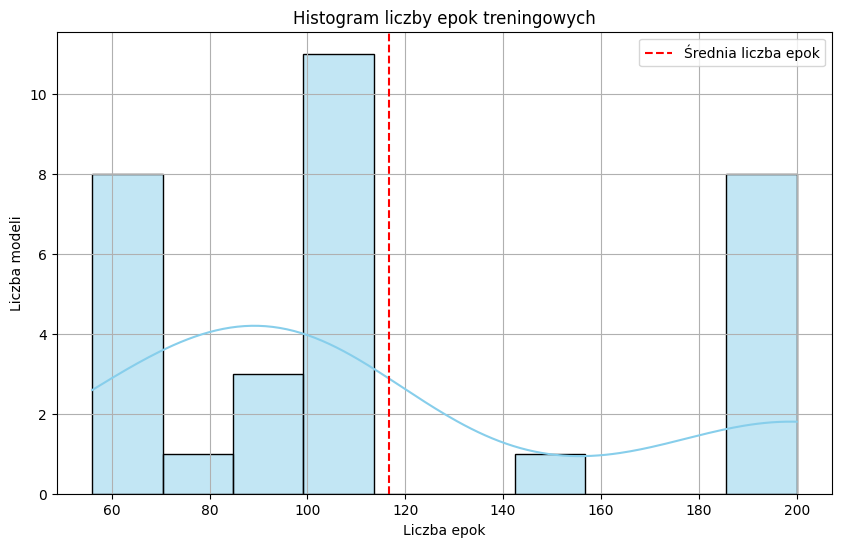

In [18]:
# Analiza liczby epok dla każdego modelu
plt.figure(figsize=(10, 6))
sns.histplot(results_df["epochs"], bins=10, kde=True, color="skyblue", edgecolor="black")
plt.axvline(results_df["epochs"].mean(), color="red", linestyle="--", label="Średnia liczba epok")
plt.title("Histogram liczby epok treningowych")
plt.xlabel("Liczba epok")
plt.ylabel("Liczba modeli")
plt.legend()
plt.grid(True)
plt.show()


sorted_results.head(3): Dane dotyczące trzech najlepszych modeli, wyselekcjonowane na podstawie dokładności walidacyjnej.
train_losses, val_losses: Straty treningowe i walidacyjne dla każdego modelu.
val_accuracies: Dokładności walidacyjne dla każdego modelu.

Pętla po modelach:

Iteruje po trzech najlepszych modelach (sorted_results.head(3)).
Dla każdego modelu pobierane są straty (train_losses, val_losses) i dokładności walidacyjne (val_accuracies).
Tworzenie wykresów:

Podział na podwykresy (plt.subplot):
Pierwszy wykres (1, 2, 1) przedstawia straty treningowe i walidacyjne.
Drugi wykres (1, 2, 2) przedstawia dokładność walidacyjną.

Wykres strat:
plt.plot rysuje przebiegi strat treningowych (kolor niebieski) i walidacyjnych (kolor czerwony).

Wykres dokładności walidacyjnej:
plt.plot rysuje przebieg dokładności walidacyjnej (kolor zielony).

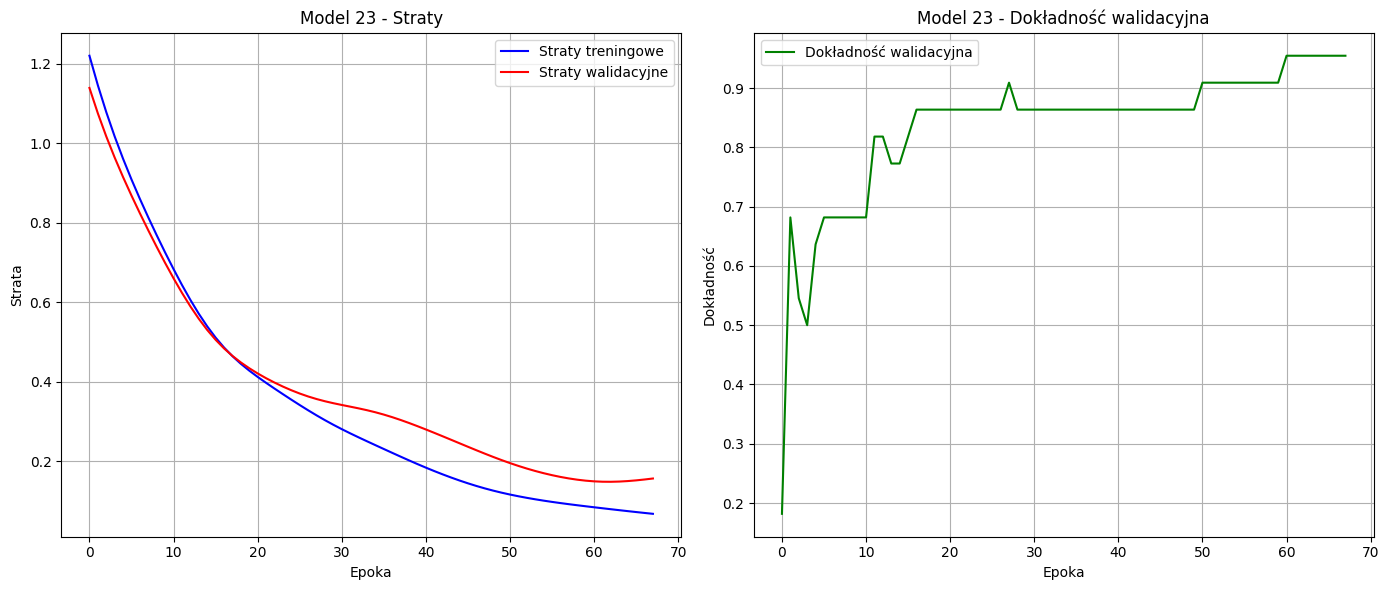

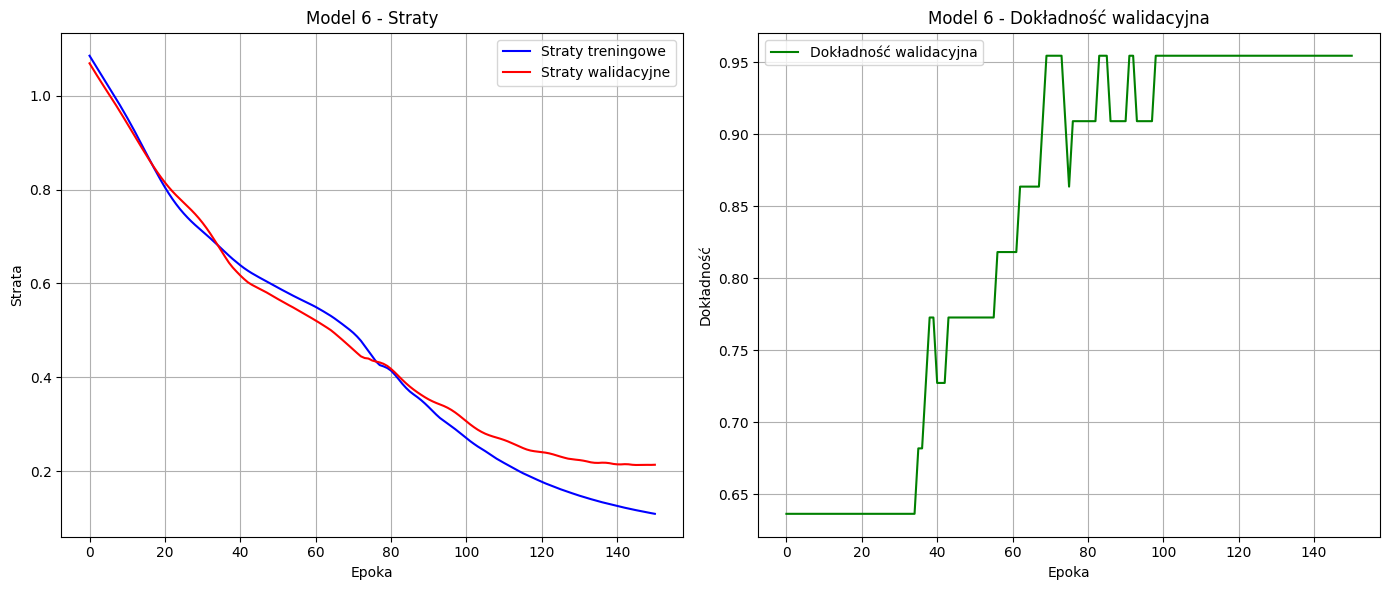

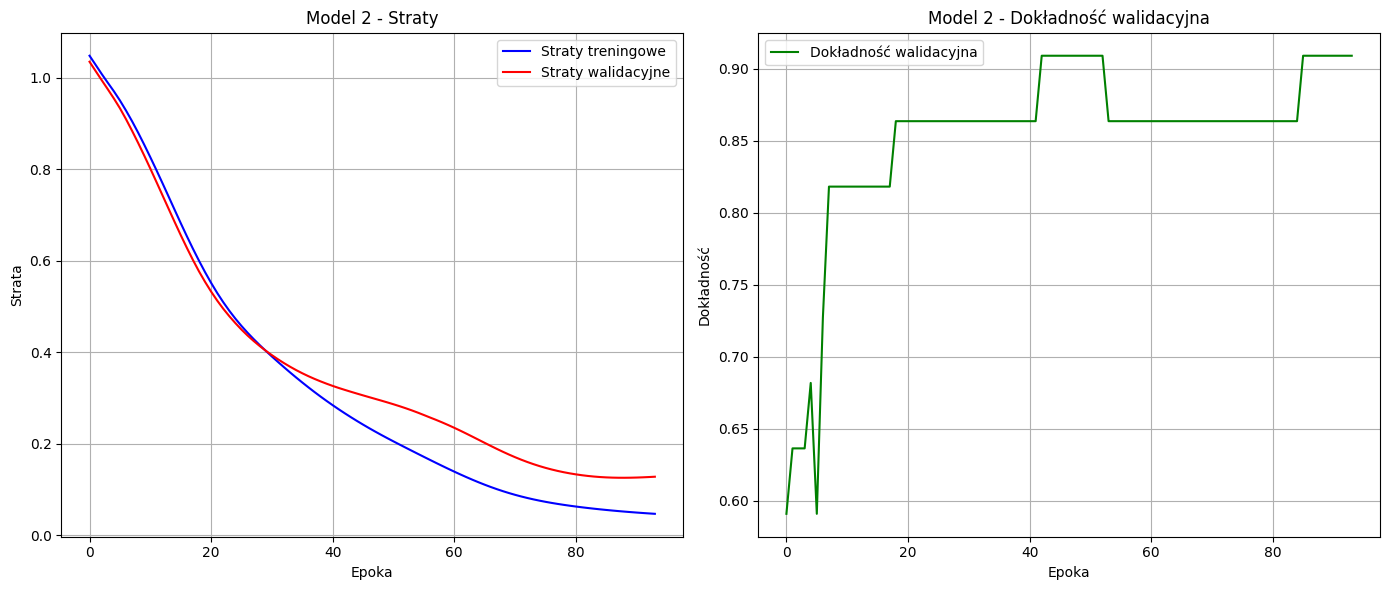

In [19]:
for idx, row in sorted_results.head(3).iterrows():
    train_losses = row["train_losses"]
    val_losses = row["val_losses"]
    val_accuracies = row["val_accuracies"]
    
    plt.figure(figsize=(14, 6))
    
    # Straty
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Straty treningowe", color="blue")
    plt.plot(val_losses, label="Straty walidacyjne", color="red")
    plt.title(f"Model {idx} - Straty")
    plt.xlabel("Epoka")
    plt.ylabel("Strata")
    plt.legend()
    plt.grid(True)
    
    # Dokładności walidacyjne
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label="Dokładność walidacyjna", color="green")
    plt.title(f"Model {idx} - Dokładność walidacyjna")
    plt.xlabel("Epoka")
    plt.ylabel("Dokładność")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


results_df: DataFrame zawierający wyniki testów różnych modeli, w tym wartości Learning Rate oraz dokładność walidacyjną (final_val_accuracy).

Ustawienia wykresu:
plt.figure(figsize=(10, 6)): Tworzy nowy wykres o rozmiarze 10x6 cali.
Rysowanie boxplota:
sns.boxplot: Tworzy wykres pudełkowy (boxplot), który pokazuje rozkład dokładności walidacyjnej (final_val_accuracy) dla różnych wartości Learning Rate (learning_rate).

C:\Users\Zuri\AppData\Local\Temp\ipykernel_18092\4055400276.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="learning_rate", y="final_val_accuracy", data=results_df, palette="pastel")


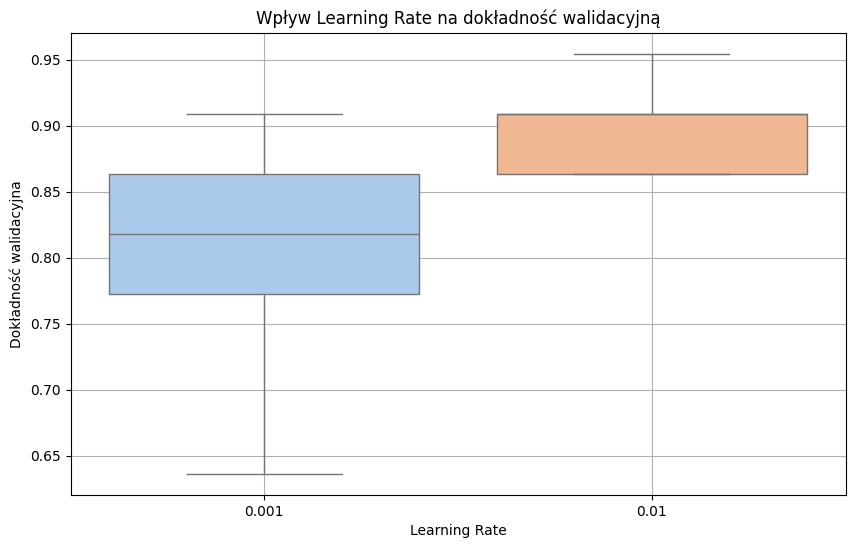

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="learning_rate", y="final_val_accuracy", data=results_df, palette="pastel")
plt.title("Wpływ Learning Rate na dokładność walidacyjną")
plt.xlabel("Learning Rate")
plt.ylabel("Dokładność walidacyjna")
plt.grid(True)
plt.show()

Średnia dokładność walidacyjna: Wskazuje przeciętną skuteczność modeli na danych walidacyjnych.
Odchylenie standardowe dokładności: Wartość ta informuje o zmienności wyników modeli – niska wartość sugeruje, że modele są stabilne i osiągają zbliżone wyniki.
Średnia liczba epok: Określa, ile epok przeciętnie trwał trening modeli.
Odchylenie standardowe liczby epok: Informuje, jak bardzo liczba epok treningowych różniła się między eksperymentami.

In [21]:
mean_accuracy = results_df["final_val_accuracy"].mean()
std_accuracy = results_df["final_val_accuracy"].std()
mean_epochs = results_df["epochs"].mean()
std_epochs = results_df["epochs"].std()

print("Statystyki wyników modeli:")
print(f"Średnia dokładność walidacyjna: {mean_accuracy:.4f}")
print(f"Odchylenie standardowe dokładności walidacyjnej: {std_accuracy:.4f}")
print(f"Średnia liczba epok treningowych: {mean_epochs:.2f}")
print(f"Odchylenie standardowe liczby epok: {std_epochs:.2f}")


Statystyki wyników modeli:
Średnia dokładność walidacyjna: 0.8466
Odchylenie standardowe dokładności walidacyjnej: 0.0789
Średnia liczba epok treningowych: 116.66
Odchylenie standardowe liczby epok: 52.22


In [22]:
print("Podsumowanie najlepszych modeli:")
print(sorted_results.head(5))

Podsumowanie najlepszych modeli:
    hidden_size1  hidden_size2  learning_rate  epochs activation1 activation2  \
23            16             8           0.01      68        Tanh        Tanh   
6              8             4           0.01     151        Tanh        ReLU   
2              8             4           0.01      94        Tanh        ReLU   
22            16             8           0.01      66        Tanh        ReLU   
4              8             4           0.01      81        ReLU        ReLU   

                                         train_losses  \
23  [1.2198669910430908, 1.1455351114273071, 1.078...   
6   [1.0851348638534546, 1.0720797777175903, 1.059...   
2   [1.0483421087265015, 1.028469443321228, 1.0084...   
22  [1.2250239849090576, 1.1627196073532104, 1.118...   
4   [1.1407437324523926, 1.1274179220199585, 1.116...   

                                           val_losses  \
23  [1.1388990879058838, 1.0749015808105469, 1.016...   
6   [1.0689390897750854